In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/give-me-some-credit-dataset/Data Dictionary.xls
/kaggle/input/give-me-some-credit-dataset/cs-training.csv
/kaggle/input/give-me-some-credit-dataset/sampleEntry.csv
/kaggle/input/give-me-some-credit-dataset/cs-test.csv


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, LogisticRegression

In [3]:
df=pd.read_csv("/kaggle/input/give-me-some-credit-dataset/cs-training.csv",index_col=0)
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
y=df["SeriousDlqin2yrs"]
X=df.drop(columns=["SeriousDlqin2yrs"])

In [5]:
#fill missing values
X=X.fillna(X.median())

#Remove invalid age rows
X=X[X["age"]>0]
y=y.loc[X.index]
print(X.shape)

(149999, 10)


In [6]:
# RAWNESS Score R(D)

#Feature dominance
feature_var=X.var()
R_dominance=feature_var.max()/feature_var.mean()
#Skewness
R_skew=X.skew().abs().mean()

#Proxy correlation
corr=X.corr().abs()
np.fill_diagonal(corr.values,0)
R_proxy=corr.max().max()

#final rawnwss
R=np.mean([float(R_dominance),float(R_skew),float(R_proxy)])
R=min(R,1.0)

print("Rawness Score:",R)

print("Dominance:", R_dominance)
print("Skew:", R_skew)
print("Proxy:", R_proxy)


Rawness Score: 1.0
Dominance: 9.752586093950235
Skew: 39.543914025435626
Proxy: 0.9927961825311732


In [7]:
#Attribute Bias Score(ABS)
ABS={}

for col in X.columns:
    dominance=X[col].var()/X.var().mean()
    cardinality=X[col].nunique()/len(X)
    instability=X[col].std()

    ABS[col]=dominance+cardinality+instability
ABS=pd.Series(ABS).sort_values(ascending=False)
ABS
mean_abs= ABS.mean()
print("ABS per feature:\n", ABS)
print("Mean ABS:", mean_abs)


ABS per feature:
 MonthlyIncome                           12900.281679
DebtRatio                                2038.830140
RevolvingUtilizationOfUnsecuredLines      250.598056
age                                        14.771877
NumberOfOpenCreditLinesAndLoans             5.146352
NumberOfTime30-59DaysPastDueNotWorse        4.192903
NumberOfTimes90DaysLate                     4.169445
NumberOfTime60-89DaysPastDueNotWorse        4.155281
NumberRealEstateLoansOrLines                1.129959
NumberOfDependents                          1.107107
dtype: float64
Mean ABS: 1522.4382798993474


In [8]:
tau_0=ABS.mean()
tau=tau_0*(1+R)

S_star=ABS[ABS>tau].index.tolist()
print("Sensitive-like featires detected:")
print(S_star)

Sensitive-like featires detected:
['MonthlyIncome']


In [9]:
reg = LinearRegression()
reg.fit(X[["MonthlyIncome"]], X["DebtRatio"])

projection = reg.predict(X[["MonthlyIncome"]])
X["DebtRatio_orth"] = X["DebtRatio"] - projection


In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Use the target you already have
y_class = y.copy()  # already binary: 0 or 1

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y_class)  # include sample_weight=weights if you have them

# Create a perturbed version of X_scaled
epsilon = 0.01
perturb = X_scaled + epsilon * np.random.randn(*X_scaled.shape)

# Predict probabilities
pred1 = model.predict_proba(X_scaled)[:, 1]
pred2 = model.predict_proba(perturb)[:, 1]

# Compute stability
stability = np.mean(np.abs(pred1 - pred2))
print("Stability:", stability)


Stability: 0.002252098328440152


In [11]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Fit nearest neighbors on your scaled features
nn = NearestNeighbors(n_neighbors=5)  # for example, 5 neighbors
nn.fit(X_scaled)
distances, neighbors = nn.kneighbors(X_scaled)

# Compute consistency
consistency = np.mean([
    np.abs(pred1[i] - pred1[neighbors[i]]).mean()  # mean difference with neighbors
    for i in range(len(pred1))
])

print("Individual Consistency:", consistency)



Individual Consistency: 0.006545727734180641


In [12]:
# If you want to compute ABS after perturbation
import pandas as pd
X_transformed = pd.DataFrame(perturb, columns=X.columns)


In [13]:
ABS_after = {}

for col in X_transformed.columns:
    dominance = X_transformed[col].var() / X_transformed.var().mean()
    cardinality = X_transformed[col].nunique() / len(X_transformed)
    instability = X_transformed[col].std()
    ABS_after[col] = dominance + cardinality + instability

ABS_after = pd.Series(ABS_after).sort_values(ascending=False)


In [14]:
ABS_before = {}

for col in X.columns:
    dominance = X[col].var() / X.var().mean()
    cardinality = X[col].nunique() / len(X)
    instability = X[col].std()
    ABS_before[col] = dominance + cardinality + instability

ABS_before = pd.Series(ABS_before).sort_values(ascending=False)

# Compare mean ABS
mean_before = ABS_before.mean()
mean_after = ABS_after.mean()

print("Mean rawness before:", mean_before)
print("Mean rawness after:", mean_after)

if mean_after < mean_before:
    print("Bias has reduced after transformation")
else:
    print("Bias did not reduce")


Mean rawness before: 1569.4237821893958
Mean rawness after: 3.000056624816581
Bias has reduced after transformation


In [15]:
ABS_before.head(10)  # Top 10 most biased features before
ABS_after.head(10)   # Top 10 most biased features after


NumberRealEstateLoansOrLines            3.000145
MonthlyIncome                           3.000091
NumberOfOpenCreditLinesAndLoans         3.000085
RevolvingUtilizationOfUnsecuredLines    3.000065
NumberOfTimes90DaysLate                 3.000062
NumberOfDependents                      3.000060
NumberOfTime30-59DaysPastDueNotWorse    3.000056
NumberOfTime60-89DaysPastDueNotWorse    3.000048
age                                     3.000041
DebtRatio_orth                          3.000033
dtype: float64

In [16]:
print("Top biased features before:")
print(ABS_before.head(10))

print("Top biased features after:")
print(ABS_after.head(10))


Top biased features before:
MonthlyIncome                           12901.001764
DebtRatio                                2038.848136
DebtRatio_orth                           2038.540452
RevolvingUtilizationOfUnsecuredLines      250.598327
age                                        14.771878
NumberOfOpenCreditLinesAndLoans             5.146353
NumberOfTime30-59DaysPastDueNotWorse        4.192903
NumberOfTimes90DaysLate                     4.169445
NumberOfTime60-89DaysPastDueNotWorse        4.155281
NumberRealEstateLoansOrLines                1.129959
dtype: float64
Top biased features after:
NumberRealEstateLoansOrLines            3.000145
MonthlyIncome                           3.000091
NumberOfOpenCreditLinesAndLoans         3.000085
RevolvingUtilizationOfUnsecuredLines    3.000065
NumberOfTimes90DaysLate                 3.000062
NumberOfDependents                      3.000060
NumberOfTime30-59DaysPastDueNotWorse    3.000056
NumberOfTime60-89DaysPastDueNotWorse    3.000048
age     

In [17]:
R = 0.2
tau_after = ABS_after.mean() * (1 + R)
S_after = ABS_after[ABS_after > tau_after].index.tolist()
print("Number of sensitive-like features after:", len(S_after))


Number of sensitive-like features after: 0


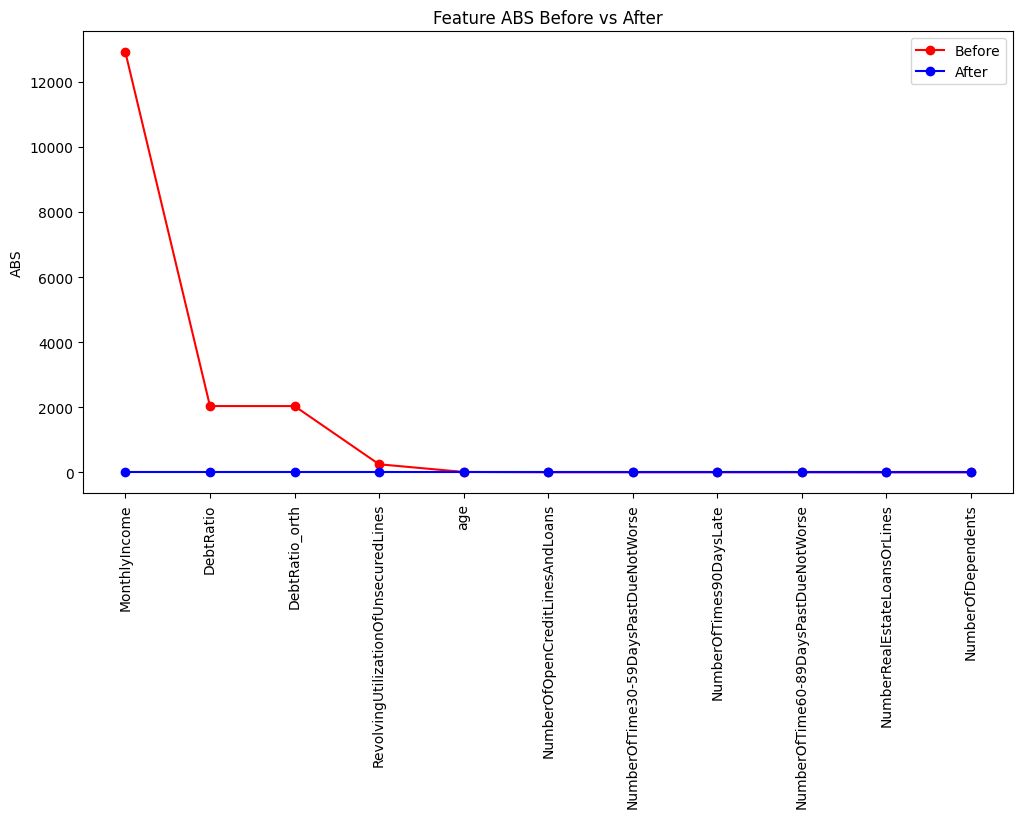

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(ABS_before.values, 'ro-', label='Before')
plt.plot(ABS_after.values, 'bo-', label='After')
plt.xticks(range(len(ABS_before)), ABS_before.index, rotation=90)
plt.ylabel('ABS')
plt.title('Feature ABS Before vs After')
plt.legend()
plt.show()


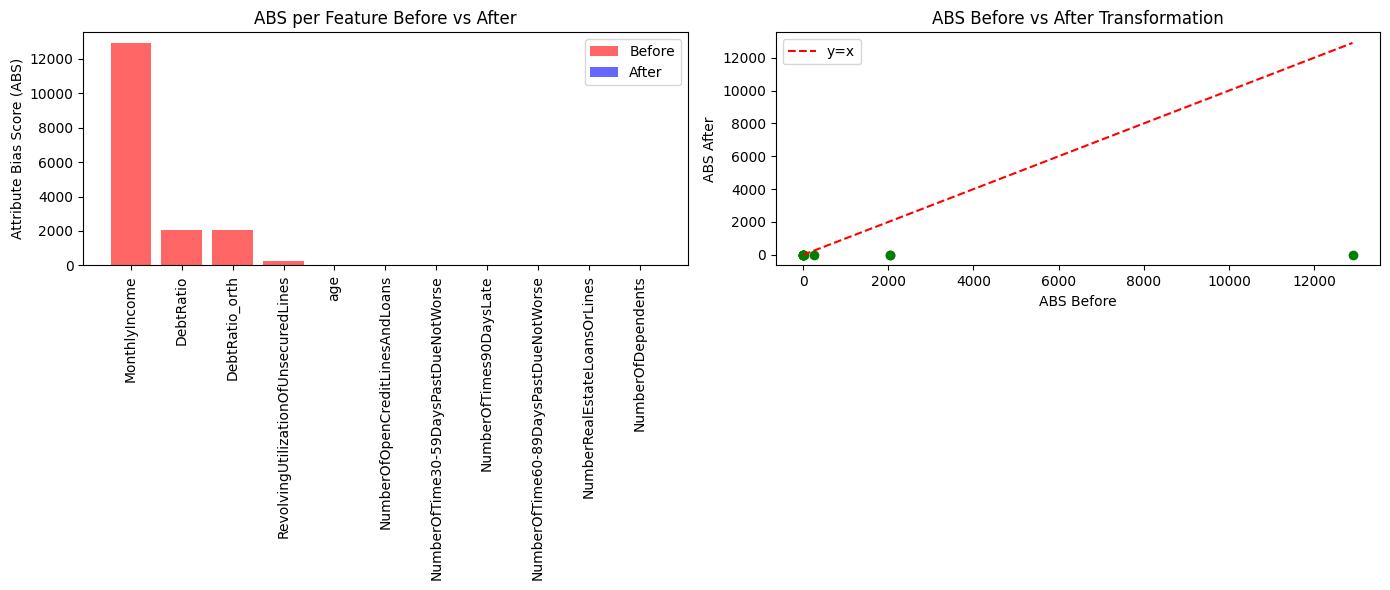

In [19]:
import matplotlib.pyplot as plt

# Ensure ABS_before and ABS_after are aligned
features = ABS_before.index

plt.figure(figsize=(14,6))

# 1️⃣ Bar plot per feature
plt.subplot(1,2,1)
plt.bar(features, ABS_before.values, alpha=0.6, label='Before', color='red')
plt.bar(features, ABS_after.values, alpha=0.6, label='After', color='blue')
plt.xticks(rotation=90)
plt.ylabel('Attribute Bias Score (ABS)')
plt.title('ABS per Feature Before vs After')
plt.legend()

# 2️⃣ Scatter plot: Before vs After
plt.subplot(1,2,2)
plt.scatter(ABS_before.values, ABS_after.values, color='green')
plt.plot([0, max(ABS_before.max(), ABS_after.max())],
         [0, max(ABS_before.max(), ABS_after.max())],
         'r--', label='y=x')  # diagonal line
plt.xlabel('ABS Before')
plt.ylabel('ABS After')
plt.title('ABS Before vs After Transformation')
plt.legend()

plt.tight_layout()
plt.show()
